# **■■ STL10のデータセットを用いた、画像認識モデルの構築 ～ResNet風～ ■■**


## **◆目次**
* はじめに
* ライブラリのインポート
* ResNet風CNNの実装
* Pathの定義
* データの前処理と読み込みの定義
* 学習・評価関数の定義
* 可視化の定義
* 学習前の設定
* モデルの初期化
* 学習ループの実行
* モデルの可視化
* おわりに

## **▼はじめに**


このノートブックでは、  
**STL10のデータセット** を用いて画像分類モデルの構築に取り組んでいます。  
  
前回作成した「STL10_Classifier_a_la_AlexNet_Base」をベースとしつつ、  
本ノートブックでは新たに **残差ブロック（Residual Block）** を導入し、  
より深く高性能なネットワークである **ResNet風モデル** を構築しました。  

**～ 本ノートブックの目的 ～**
* **残差接続の導入** による性能改善の検証
* 自作CNN構造から **ResNet型** への発展的構築の実践  
  
深層化による勾配消失問題を解消する手法として知られる **Residual構造** を、自前の実装に組み込むことで、  
**モデルの学習効率や精度の向上がどの程度得られるのか** を実験・観察しています。

**～ 主な変更点 ～**
* **分類モデル**：AlexNetベース => ResNet風アーキテクチャへ
* **構造追加**：Residual Block および Residual Stack を自作実装
* **解説内容**：モデル構造・学習設計・実装コードを大幅に更新

## **▼ライブラリのインポート**


In [ ]:
# セッション再起動後、再度AllRun
!pip install torchinfo
!pip install torchcam

In [ ]:
import os
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# deviceの設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


必要なライブラリをインポートします。
* *"tqdm"* : プログレスバー表示用
* *"matplotlib"* : グラフ描画用
* *"torch"*, *"torch.nn"* : PyTorchの基本モジュール
* *"torchinfo"* : モデルの詳細表示用
* *"torchvision"* : データセットや画像変換用
* *"torchcam"* : Class Activation Map表示用

## **▼ResNet風CNNの実装**


### **ResNetの構造（概要）**


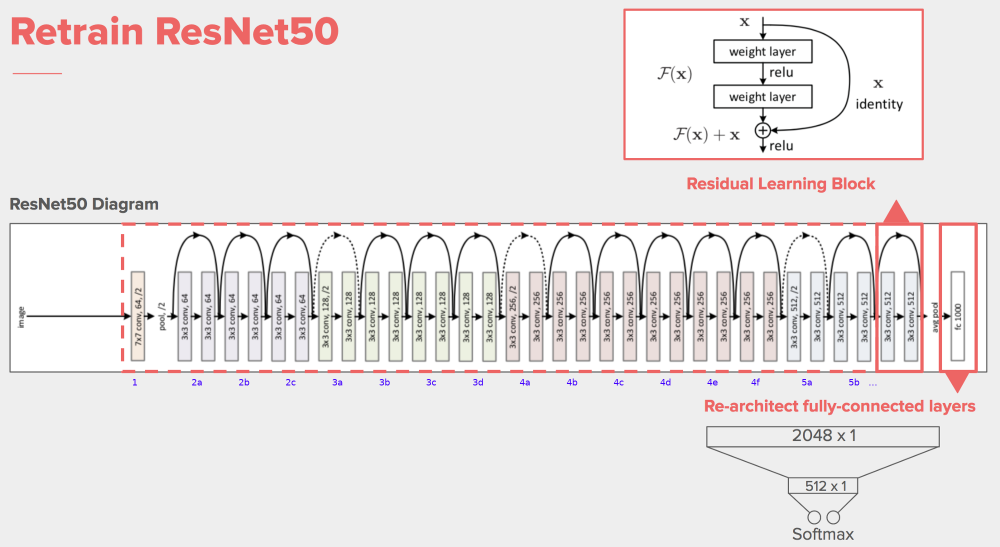

**～ ResNet（Residual Network）とは？ ～**
* 2015年にMicrosoft Researchが発表した深層学習のためのCNNである
* **「残差学習（Residual Learning）」** という革新的なアプローチ
* **非常に深いネットワークでも学習が可能** になり、従来のCNNの精度・安定性を大きく向上させた
* ILSVRC 2015 では、 **圧倒的な精度で優勝** し、現在でも画像認識（分類、検出、セグメンテーションなど）で標準的に使われている
* 元のデータを**スキップ接続（identity mapping）** によって加えることで、元のデータを崩さない構造となっている
* 発表されたモデルには **ResNet18、34、50、101、152** とあり、層の深さを表している

### **残差ブロック（Residual Block）の実装**


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, stride=1, downsample=None):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_dim)
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.block(x)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

**～ ResiDual Block とは ～**  
  
**Residual Block（残差ブロック）** とは、  
**深層ニューラルネットワークにおける情報の劣化や勾配消失問題** を緩和するために導入された構造です。  
ResNetにおいて重要な要素であり、**「入力をそのまま出力へスキップ（shortcut）」**させます。  
* 層が深くなっても学習が安定する
* 勾配が深い層まで届きやすくなる
* 必要に応じて「何もしない層」として振舞うことが可能  


**～ 基本構造 ～**
* 通常の畳み込み（Conv） → 活性化関数（ReLU） → BatchNorm
* もう一度Conv → ReLU → BatchNorm
* 最初の入力（identity）をスキップ接続で加算（residual connection）

### **残差スタック（Residual Stack）の実装**


In [ ]:
class ResidualStack(nn.Module):
    def __init__(self, input_dim, output_dim, num_blocks, stride=1):
        super().__init__()
        downsample = None
        if stride != 1 or input_dim != output_dim:
            downsample = nn.Sequential(
                nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_dim)
            )

        layers = []
        layers.append(ResidualBlock(input_dim, output_dim, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(output_dim, output_dim))
        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.stack(x)

**～ ResiDual Stack とは ～**  
  
**Residual Stack（残差スタック）** とは、  
**複数のResidual Blockを直列に積み重ねた構造** によって、ネットワークはより深くなりながらも、  
**スキップ接続** によって情報の流れがスムーズに保たれ、高次の特徴を効率的に学習できるようになります。

**～ 構成と役割 ～**
* **複数のResidual Block** を連続して並べた構造
* 中間層で特徴抽出の段階的な深化を担う
* 特に画像認識では、**抽象度の高い特徴（形状・輪郭・質感など）**を捉えるのに有効

### **ResNet風CNNの実装**


In [ ]:
class CNN_a_la_ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):         # 96*96=>48*48=>24*24=>12*12=>6*6
        super().__init__()
        self.layers = nn.ModuleDict({
            "layer1": nn.Sequential(
                nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),   # 96*96=>96*96
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
            ),
            "layer2": ResidualStack(hidden_dim, hidden_dim, num_blocks=1, stride=1),              # 96*96=>96*96
            "layer3": ResidualStack(hidden_dim, hidden_dim*2, num_blocks=3, stride=2),            # 96*96=>48*48
            "layer4": ResidualStack(hidden_dim*2, hidden_dim*4, num_blocks=4, stride=2),            # 48*48=>24*24
            "layer5": ResidualStack(hidden_dim*4, hidden_dim*8, num_blocks=3, stride=2),           # 24*24=>12*12
            "avgpool": nn.AdaptiveAvgPool2d((1, 1)),
            "flatten": nn.Flatten(),
            "fc": nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(hidden_dim*8, output_dim)
            )
        })

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x

**ResNet18**　では、Residual Block の数を **2=>2=>2=>2** にすることで、総畳み込み回数が18回（(2+2+2+2)×2+2）となっており、  
また、**ResNet34**　では、Residual Block の数を **3=>4=>6=>3** にすることで、総畳み込み回数が34回（(3+4+6+3)×2+2）となっている。

**～ ResNetの利点 ～**  
* **残差ブロック（Residual Block）** を導入することにより、「変化分だけの学習」となり、**情報の伝達をスムーズ** に
* 転移学習やほかモデルへのバックボーンとして利用されるほど、**汎化性能** が優れている

**「深い学習ができる」**、**「精度が高い」**、**「汎化性能がある」** という3点がそろっており、深層学習として非常に優秀なモデルである。

## **▼Pathの定義**


In [ ]:
def get_paths():
    # 相対パスの取得
    path = Path(".")

    # Pathの設定
    data_path = path / "data"

    input_path = data_path / "input"
    model_path = data_path / "model"

    bestmodel_path = model_path / "best_model.pth"

    # フォルダの作成
    input_path.mkdir(parents=True, exist_ok=True)
    model_path.mkdir(parents=True, exist_ok=True)

    return bestmodel_path, input_path

input用フォルダ・model用フォルダを作成し、bestmodel用のパスも設定します。


## **▼データの前処理と読み込みの定義**


In [ ]:
# データの前処理と読み込み
def get_loader(root, mean, std, batch_size, num_workers):
    # データの拡張(Augmentation)の設定（下記に詳細あり）
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    transform_test = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # STL10データセットの取得
    train_datasets = datasets.STL10(root, split='train', download=True, transform=transform_train)
    test_datasets = datasets.STL10(root, split='test', download=True, transform=transform_test)

    # ローダーの設定
    train_dataloader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, test_dataloader

データセットを読み込み、前処理を行います。


～ **STL10とは？** ～

* 96×96pixelのカラー画像
* 10クラスの物体分類データセット
* train: 5,000枚（各クラス500枚）、test: 8,000枚（各クラス800枚）
* クラス: 飛行機、自動車、鳥、猫、鹿、犬、カエル、馬、船、トラック

～ **前処理** ～

* train: データ拡張（Augmentation）を適用し、汎用性の向上
* test: 正規化のみ（データ拡張なし）
* 正規化: 0～1の数値の mean を0になるようにして、 std の幅が1になるように設定

～ **データ拡張** ～

* RandomResizedCrop: 画像のランダム切り抜き
* RandomHorizontalFlip: 画像の左右反転
* RandomVerticalFlip: 画像の上下反転
* ColorJitter: 画像の色ランダム調整
* Resize: 画像サイズの調整
* ToTensor: 0～255 を 0～1 のテンソル型変換
* Normalized: 正規化

## **▼学習・評価関数の定義**


### **学習関数（train）の定義**


In [ ]:
def train(model, train_dataloader, criterion, optimizer, device):
    # 訓練モード
    model.train()

    # 変数の設定
    total = 0
    loss_total = 0
    correct = 0

    # progress barの設定
    pbar = tqdm(train_dataloader, desc="    train")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # 勾配初期化
        optimizer.zero_grad()

        # 予測の出力
        outputs = model(images)

        # 予測に基づくロス計算と最適化
        total += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # ロスと正確度の算出
        loss_total += loss.item()
        outputs, labels = outputs.cpu(), labels.cpu()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()

        # ロスと正確度の表示(progress bar)
        pbar.set_postfix({
            "Loss": f"{loss_total / (pbar.n+1):.4f}",
            "Acc": f"{100 * correct / total:.2f}%"
        })

    # ロスと正確度の算出
    loss = loss_total / len(train_dataloader)
    acc = 100 * correct / total

    return loss, acc

### **評価関数（evaluate）の定義**


In [ ]:
def evaluate(model, test_dataloader, criterion, device):
    # 評価モード
    model.eval()

    # 変数の設定
    total = 0
    loss_total = 0
    correct = 0

    # 勾配計算の無効化
    with torch.no_grad():

        # progress barの設定
        pbar = tqdm(test_dataloader, desc="    test ")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # 予測とロスの出力
            outputs = model(images)
            loss = criterion(outputs, labels)

            # ロスと正確度の算出
            total += len(labels)
            loss_total += loss.item()
            outputs, labels = outputs.cpu(), labels.cpu()
            predict = torch.argmax(outputs, dim=1)
            correct += (predict == labels).sum().item()

            # ロスと正確度の表示(progress bar)
            pbar.set_postfix({
                "Loss": f"{loss_total / (pbar.n+1):.4f}",
                "Acc": f"{100 * correct / total:.2f}%"
            })

        # ロスと正確度の算出
        loss = loss_total / len(test_dataloader)
        acc = 100 * correct / total

    return loss, acc

* tqdm の プログレスバー によって、進捗を可視化
* 学習曲線の作図のため、返り値に各 loss と acc を設定

## **▼可視化の定義**


### **画像の表示の定義**


In [ ]:
# 元画像に戻す関数の定義
def denormalize(x_norm, mean, std):
    return x_norm * std + mean

In [ ]:
# 画像の出力の定義
def show_images_STL10(dataloader, rows=3, model=None, denormalized=True):
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        break

    # 画像の表示の設定
    label_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
    plt.figure(figsize=(16, 6))
    for i in range(8*rows):
        plt.subplot(rows, 8, i+1)
        image = images[i]
        if denormalized == True:
            image = denormalize(image, 0.4, 0.3)
        image = image.permute(1, 2, 0).cpu()
        image = torch.clip(image, 0, 1)
        plt.imshow(image)

        label = label_names[labels[i].item()]

        # model != None の場合
        if model is not None:
            model.eval()
            with torch.no_grad():
                outputs = model(images[i].unsqueeze(0))
                predict = torch.argmax(outputs, dim=1)
                model_label = label_names[predict.item()]

                # 出力が正解の場合、緑
                if label == model_label:
                    plt.title(f"{label} / {model_label}", color="green")

                # 出力が不正解の場合、赤
                else:
                    plt.title(f"{label} / {model_label}", color="red")
            plt.axis('off')

        # model == None の場合
        else:
            plt.title(label)
            plt.axis('off')

    # 画像の表示
    plt.tight_layout()
    plt.show()

### **学習曲線の表示の定義**


In [ ]:
def show_learning_curve(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train", color="blue", alpha=0.6)
    plt.plot(test_losses, label="test", color="red", alpha=0.6)
    plt.title("Learning Curve - Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="train", color="blue", alpha=0.6)
    plt.plot(test_accs, label="test", color="red", alpha=0.6)
    plt.title("Learning Curve - Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### **Class Activation Mapの表示の定義**


In [ ]:
def show_CAM_STL10(test_dataloader, model):
    # ベストモデルの認識の可視化
    for images, _ in test_dataloader:
        images = images.to(device)
        break

    plt.figure(figsize=(16, 3))

    # 評価モード
    model.eval()

    for i in range(8):
        # 画像認識の抽出設定
        cam_extractor = SmoothGradCAMpp(model, target_layer=model.layers["layer5"])

        # 画像の出力抽出
        image = images[i].unsqueeze(0)

        # 勾配計算を可能にするために、入力画像にrequires_gradをTrueに設定
        image.requires_grad_(True)

        output = model(image)
        output = output.cpu()
        class_idx = torch.argmax(output, dim=1).item()

        # 抽出の画像化
        activation_map = cam_extractor(class_idx, output)

        # 元画像との合成
        result = overlay_mask(
            to_pil_image(image.squeeze(0).cpu().detach()),
            to_pil_image(activation_map[0].squeeze(0), mode="F"),
            alpha=0.5
        )

        # 画像の表示設定
        plt.subplot(1, 8, i+1)
        plt.imshow(result)
        plt.axis('off')

        # 抽出用ホックの削除
        cam_extractor.remove_hooks()

    # 画像の表示
    plt.tight_layout()
    plt.show()

    # 比較用画像の表示
    show_images_STL10(test_dataloader, 1, model)

～ **Class Activation Map（CAM）** とは？ ～  

モデルが画像を分類する際に「どの部分に注目して判断したのか」を可視化したものです。  
モデル内部の特徴マップと、出力層の重み情報を組み合わせることで、  
**「この画像のどこがそのクラスらしさに貢献しているか」** を視覚的に理解することができます。  

## **▼学習前の設定**


In [ ]:
# pathの設定
bestmodel_path, input_path = get_paths()

# ハイパーパラメータの設定
root = input_path
batch_size = 64
num_workers = 4
lr = 0.0005
EPOCH = 150
best_acc = 0

# モデルのパラメータ設定
input_dim = 3
hidden_dim = 64
output_dim = 10
dropout = 0.2

# データローダーの取得
print("STL10 の データセットを読み込んでいます...")
train_dataloader, test_dataloader = get_loader(root, 0.4, 0.3, batch_size, num_workers=num_workers)
print("STL10 の データセットの読み込みを完了しました。")

STL10 の データセットを読み込んでいます...


100%|██████████| 2.64G/2.64G [13:13<00:00, 3.33MB/s]


STL10 の データセットの読み込みを完了しました。


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


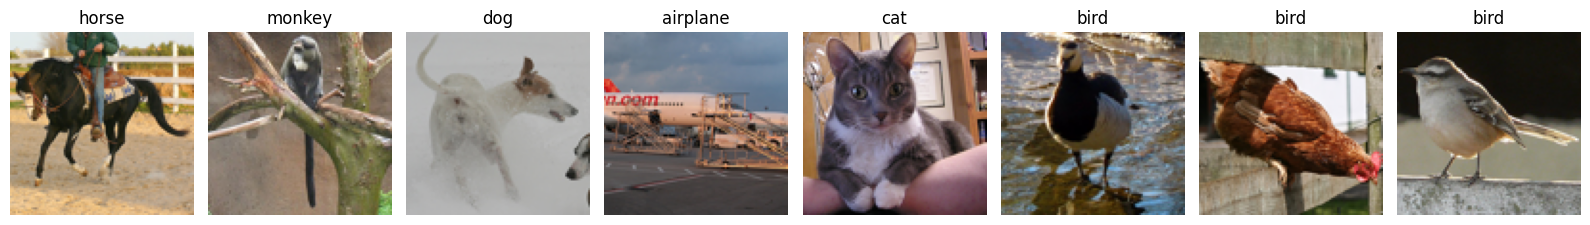

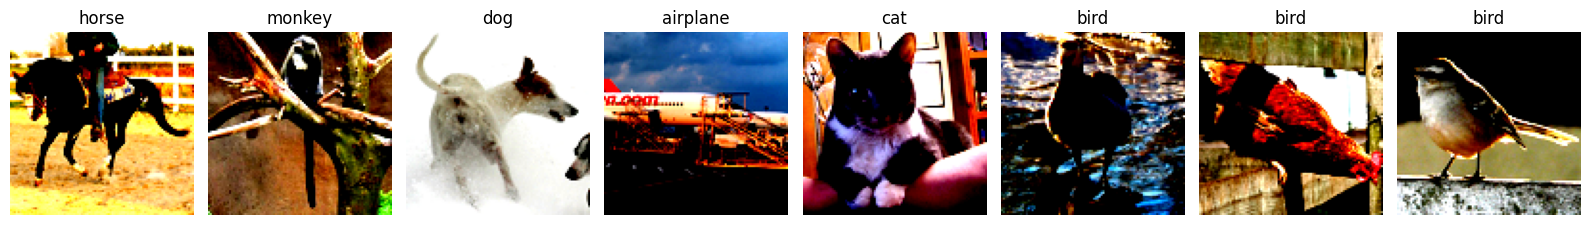

In [ ]:
# テスト用画像の出力
show_images_STL10(test_dataloader, 1, denormalized=True)
# モデル用画像の出力
show_images_STL10(test_dataloader, 1, denormalized=False)

2つ目の画像は正規化されたもので、モデルが読み取りやすいようになっている。

## **▼モデルの初期化**


In [ ]:
# 分類モデルの設定
model = CNN_a_la_ResNet(input_dim, hidden_dim, output_dim, 0.2).to(device)

# ロス関数・勾配最適化・スケジューラの設定
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.2)

# 学習履歴リストの作成
train_losses = []
train_accs = []
test_losses = []
test_accs = []

**～ CrossEntropyLoss とは ～**  
* ロス関数の一つで、主に **分類タスク** で使用される
* **「各クラスの確率」** に近い値を出力
* 正解ラベルに対して、予測がどれほど近いかを評価(正解を1とする)
* 正解のクラスに高い確率で予想した場合、**損失（ロス）は小さく** なる
* 正解のクラスに低い確率で予想した場合、**損失は大きく** なる

**～ AdamW とは ～**  
* **最適化アルゴリズム（Optimizer）** の一種
* Adamに **「重み減衰（Weight Decay）」** を正しく追加した改良版
* **収束の速さ** と、 **正則化による汎化性能** の向上を両立したアルゴリズム
* **勾配の平均** と **勾配の分散** の両方を使って学習率の調整を行う
* 重み減衰を **勾配更新とは独立して適用** し、過学習防止に有効である

**～ MultiStepLR とは ～**  
* **学習率（Learning Rate）** を段階的に下げるスケジューラ
* 指定したエポックで、学習率を一気に減衰させる
* 減衰比率は **gamma** によって調整することができる

In [ ]:
# 分類モデルの詳細確認
summary(model, (1, 3, 96, 96))

Layer (type:depth-idx)                             Output Shape              Param #
CNN_a_la_ResNet                                    [1, 10]                   --
├─ModuleDict: 1-1                                  --                        --
│    └─Sequential: 2-1                             [1, 64, 96, 96]           --
│    │    └─Conv2d: 3-1                            [1, 64, 96, 96]           1,728
│    │    └─BatchNorm2d: 3-2                       [1, 64, 96, 96]           128
│    │    └─ReLU: 3-3                              [1, 64, 96, 96]           --
│    └─ResidualStack: 2-2                          [1, 64, 96, 96]           --
│    │    └─Sequential: 3-4                        [1, 64, 96, 96]           73,984
│    └─ResidualStack: 2-3                          [1, 128, 48, 48]          --
│    │    └─Sequential: 3-5                        [1, 128, 48, 48]          820,992
│    └─ResidualStack: 2-4                          [1, 256, 24, 24]          --
│    │    └─Sequential

## **▼学習ループの実行**


In [ ]:
# 学習ループ
for epoch in range(EPOCH):
    print(f"[EPOCH: {epoch+1}/{EPOCH}]  learning rate: {scheduler.get_last_lr()[0]:.6f}")

    # 学習
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    # 評価
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)

    # スケジューラの更新
    scheduler.step()

    # 学習履歴リストへの追加
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # 評価スコアの高かったモデルのステータスの保存
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), bestmodel_path)
        # print()
        print(f" ✓  best model を保存しました。（精度：{best_acc:.2f}%）")

    # print("="*64)
    print()

print(f"best test acc: {best_acc:.2f}%")

[EPOCH: 1/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:17<00:00,  7.21it/s, Loss=2.0165, Acc=26.74%]


 ✓  best model を保存しました。（精度：26.74%）

[EPOCH: 2/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=1.8403, Acc=28.85%]


 ✓  best model を保存しました。（精度：28.85%）

[EPOCH: 3/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:17<00:00,  7.04it/s, Loss=1.6251, Acc=34.16%]


 ✓  best model を保存しました。（精度：34.16%）

[EPOCH: 4/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:17<00:00,  6.96it/s, Loss=1.6880, Acc=33.75%]



[EPOCH: 5/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.93it/s, Loss=1.6861, Acc=35.09%]


 ✓  best model を保存しました。（精度：35.09%）

[EPOCH: 6/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.90it/s, Loss=1.5472, Acc=40.11%]


 ✓  best model を保存しました。（精度：40.11%）

[EPOCH: 7/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.91it/s, Loss=1.6057, Acc=42.30%]


 ✓  best model を保存しました。（精度：42.30%）

[EPOCH: 8/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.90it/s, Loss=1.5127, Acc=43.91%]


 ✓  best model を保存しました。（精度：43.91%）

[EPOCH: 9/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=1.3131, Acc=49.94%]


 ✓  best model を保存しました。（精度：49.94%）

[EPOCH: 10/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.91it/s, Loss=1.4448, Acc=46.17%]



[EPOCH: 11/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.90it/s, Loss=1.4185, Acc=49.45%]



[EPOCH: 12/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=1.5580, Acc=47.10%]



[EPOCH: 13/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=1.7488, Acc=39.58%]



[EPOCH: 14/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.89it/s, Loss=1.2295, Acc=54.02%]


 ✓  best model を保存しました。（精度：54.02%）

[EPOCH: 15/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=1.2261, Acc=54.81%]


 ✓  best model を保存しました。（精度：54.81%）

[EPOCH: 16/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=1.2035, Acc=56.77%]


 ✓  best model を保存しました。（精度：56.77%）

[EPOCH: 17/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.91it/s, Loss=1.1393, Acc=58.51%]


 ✓  best model を保存しました。（精度：58.51%）

[EPOCH: 18/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=1.2797, Acc=54.24%]



[EPOCH: 19/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=1.5606, Acc=48.24%]



[EPOCH: 20/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.90it/s, Loss=1.0874, Acc=60.21%]


 ✓  best model を保存しました。（精度：60.21%）

[EPOCH: 21/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.91it/s, Loss=1.0326, Acc=63.27%]


 ✓  best model を保存しました。（精度：63.27%）

[EPOCH: 22/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.9919, Acc=63.77%]


 ✓  best model を保存しました。（精度：63.77%）

[EPOCH: 23/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.90it/s, Loss=1.3298, Acc=54.50%]



[EPOCH: 24/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.90it/s, Loss=1.3034, Acc=54.94%]



[EPOCH: 25/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=1.1856, Acc=59.12%]



[EPOCH: 26/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.93it/s, Loss=1.1516, Acc=59.94%]



[EPOCH: 27/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.89it/s, Loss=0.9455, Acc=66.17%]


 ✓  best model を保存しました。（精度：66.17%）

[EPOCH: 28/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.9786, Acc=65.49%]



[EPOCH: 29/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=1.1482, Acc=60.38%]



[EPOCH: 30/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.89it/s, Loss=1.3843, Acc=53.00%]



[EPOCH: 31/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.72it/s, Loss=1.1307, Acc=60.85%]



[EPOCH: 32/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.9127, Acc=67.76%]


 ✓  best model を保存しました。（精度：67.76%）

[EPOCH: 33/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=1.0009, Acc=65.11%]



[EPOCH: 34/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=1.1133, Acc=62.14%]



[EPOCH: 35/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.9860, Acc=66.42%]



[EPOCH: 36/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=1.2815, Acc=58.27%]



[EPOCH: 37/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=1.0371, Acc=65.99%]



[EPOCH: 38/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.9561, Acc=67.00%]



[EPOCH: 39/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8770, Acc=69.04%]


 ✓  best model を保存しました。（精度：69.04%）

[EPOCH: 40/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8621, Acc=69.81%]


 ✓  best model を保存しました。（精度：69.81%）

[EPOCH: 41/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.90it/s, Loss=0.9222, Acc=68.26%]



[EPOCH: 42/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.9616, Acc=67.26%]



[EPOCH: 43/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=1.0176, Acc=65.67%]



[EPOCH: 44/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.9348, Acc=68.30%]



[EPOCH: 45/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8672, Acc=69.78%]



[EPOCH: 46/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.77it/s, Loss=0.8504, Acc=72.17%]


 ✓  best model を保存しました。（精度：72.17%）

[EPOCH: 47/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.8655, Acc=70.34%]



[EPOCH: 48/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.9616, Acc=68.39%]



[EPOCH: 49/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.79it/s, Loss=0.8368, Acc=71.64%]



[EPOCH: 50/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8282, Acc=71.05%]



[EPOCH: 51/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8661, Acc=70.69%]



[EPOCH: 52/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=0.8186, Acc=71.33%]



[EPOCH: 53/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.92it/s, Loss=0.7476, Acc=74.85%]


 ✓  best model を保存しました。（精度：74.85%）

[EPOCH: 54/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.9372, Acc=68.66%]



[EPOCH: 55/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=1.0121, Acc=67.74%]



[EPOCH: 56/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.7972, Acc=73.58%]



[EPOCH: 57/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8055, Acc=72.61%]



[EPOCH: 58/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=1.1069, Acc=67.47%]



[EPOCH: 59/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8778, Acc=72.83%]



[EPOCH: 60/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, Loss=0.9222, Acc=69.67%]



[EPOCH: 61/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8868, Acc=70.83%]



[EPOCH: 62/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.7884, Acc=74.14%]



[EPOCH: 63/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=1.1326, Acc=67.19%]



[EPOCH: 64/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8887, Acc=72.17%]



[EPOCH: 65/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.9542, Acc=72.39%]



[EPOCH: 66/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.7836, Acc=75.40%]


 ✓  best model を保存しました。（精度：75.40%）

[EPOCH: 67/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.9161, Acc=71.99%]



[EPOCH: 68/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=1.0767, Acc=69.44%]



[EPOCH: 69/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8694, Acc=72.88%]



[EPOCH: 70/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.9554, Acc=71.42%]



[EPOCH: 71/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8432, Acc=73.89%]



[EPOCH: 72/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.76it/s, Loss=0.9173, Acc=70.95%]



[EPOCH: 73/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.7271, Acc=76.81%]


 ✓  best model を保存しました。（精度：76.81%）

[EPOCH: 74/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.7938, Acc=75.67%]



[EPOCH: 75/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.76it/s, Loss=0.8068, Acc=75.64%]



[EPOCH: 76/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.7768, Acc=75.71%]



[EPOCH: 77/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.79it/s, Loss=0.8602, Acc=74.97%]



[EPOCH: 78/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.78it/s, Loss=0.8287, Acc=75.84%]



[EPOCH: 79/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.9461, Acc=73.84%]



[EPOCH: 80/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.7640, Acc=76.41%]



[EPOCH: 81/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8690, Acc=74.80%]



[EPOCH: 82/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.8746, Acc=75.14%]



[EPOCH: 83/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.9416, Acc=72.60%]



[EPOCH: 84/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.8431, Acc=75.22%]



[EPOCH: 85/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.8731, Acc=75.20%]



[EPOCH: 86/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.9497, Acc=73.05%]



[EPOCH: 87/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8020, Acc=76.40%]



[EPOCH: 88/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.8507, Acc=75.49%]



[EPOCH: 89/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, Loss=1.2259, Acc=69.25%]



[EPOCH: 90/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.9153, Acc=75.22%]



[EPOCH: 91/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, Loss=0.7842, Acc=76.97%]


 ✓  best model を保存しました。（精度：76.97%）

[EPOCH: 92/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8191, Acc=75.42%]



[EPOCH: 93/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.7290, Acc=78.42%]


 ✓  best model を保存しました。（精度：78.42%）

[EPOCH: 94/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.8280, Acc=76.76%]



[EPOCH: 95/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=0.9480, Acc=74.28%]



[EPOCH: 96/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.8976, Acc=75.06%]



[EPOCH: 97/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.7849, Acc=77.46%]



[EPOCH: 98/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8577, Acc=75.47%]



[EPOCH: 99/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8471, Acc=76.55%]



[EPOCH: 100/150]  learning rate: 0.000500


    test : 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, Loss=0.8941, Acc=75.71%]



[EPOCH: 101/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.7029, Acc=79.78%]


 ✓  best model を保存しました。（精度：79.78%）

[EPOCH: 102/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.88it/s, Loss=0.7033, Acc=80.46%]


 ✓  best model を保存しました。（精度：80.46%）

[EPOCH: 103/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.7235, Acc=79.99%]



[EPOCH: 104/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.79it/s, Loss=0.7275, Acc=80.24%]



[EPOCH: 105/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.7279, Acc=80.09%]



[EPOCH: 106/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.7348, Acc=80.05%]



[EPOCH: 107/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.77it/s, Loss=0.7377, Acc=80.39%]



[EPOCH: 108/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.7543, Acc=80.19%]



[EPOCH: 109/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.7400, Acc=80.36%]



[EPOCH: 110/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.7458, Acc=80.51%]


 ✓  best model を保存しました。（精度：80.51%）

[EPOCH: 111/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.7724, Acc=80.16%]



[EPOCH: 112/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.7919, Acc=79.62%]



[EPOCH: 113/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.79it/s, Loss=0.7642, Acc=80.26%]



[EPOCH: 114/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.7395, Acc=80.90%]


 ✓  best model を保存しました。（精度：80.90%）

[EPOCH: 115/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.7652, Acc=80.39%]



[EPOCH: 116/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.78it/s, Loss=0.8120, Acc=79.71%]



[EPOCH: 117/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.87it/s, Loss=0.7811, Acc=80.44%]



[EPOCH: 118/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.8060, Acc=79.71%]



[EPOCH: 119/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.7985, Acc=80.26%]



[EPOCH: 120/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.7916, Acc=79.92%]



[EPOCH: 121/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.86it/s, Loss=0.7812, Acc=80.25%]



[EPOCH: 122/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8121, Acc=80.49%]



[EPOCH: 123/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8146, Acc=80.35%]



[EPOCH: 124/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8300, Acc=80.08%]



[EPOCH: 125/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=0.8150, Acc=79.90%]



[EPOCH: 126/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, Loss=0.8273, Acc=80.04%]



[EPOCH: 127/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8075, Acc=80.62%]



[EPOCH: 128/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8129, Acc=80.35%]



[EPOCH: 129/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8249, Acc=79.96%]



[EPOCH: 130/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8185, Acc=80.20%]



[EPOCH: 131/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.8138, Acc=80.53%]



[EPOCH: 132/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, Loss=0.8328, Acc=80.25%]



[EPOCH: 133/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8258, Acc=80.62%]



[EPOCH: 134/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8495, Acc=80.29%]



[EPOCH: 135/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8704, Acc=79.84%]



[EPOCH: 136/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=0.8330, Acc=80.17%]



[EPOCH: 137/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8482, Acc=80.20%]



[EPOCH: 138/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8437, Acc=79.80%]



[EPOCH: 139/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=0.8309, Acc=80.40%]



[EPOCH: 140/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.78it/s, Loss=0.8392, Acc=79.96%]



[EPOCH: 141/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.85it/s, Loss=0.8653, Acc=80.08%]



[EPOCH: 142/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8440, Acc=80.60%]



[EPOCH: 143/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.74it/s, Loss=0.8502, Acc=80.38%]



[EPOCH: 144/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.84it/s, Loss=0.8788, Acc=79.64%]



[EPOCH: 145/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.80it/s, Loss=0.8272, Acc=80.36%]



[EPOCH: 146/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.73it/s, Loss=0.8770, Acc=80.31%]



[EPOCH: 147/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.82it/s, Loss=0.8493, Acc=80.15%]



[EPOCH: 148/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.81it/s, Loss=0.8372, Acc=80.56%]



[EPOCH: 149/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.76it/s, Loss=0.8503, Acc=80.61%]



[EPOCH: 150/150]  learning rate: 0.000100


    test : 100%|██████████| 125/125 [00:18<00:00,  6.83it/s, Loss=0.8782, Acc=80.29%]


best test acc: 80.90%


Best Test Acc Score: **80.90%**


## ▼モデルの可視化


In [ ]:
# ベストモデルのステータス読み込み
model = CNN_a_la_ResNet(input_dim, hidden_dim, output_dim, dropout).to(device)
model.load_state_dict(torch.load(bestmodel_path))
model.eval()

### **出力結果 による可視化**  


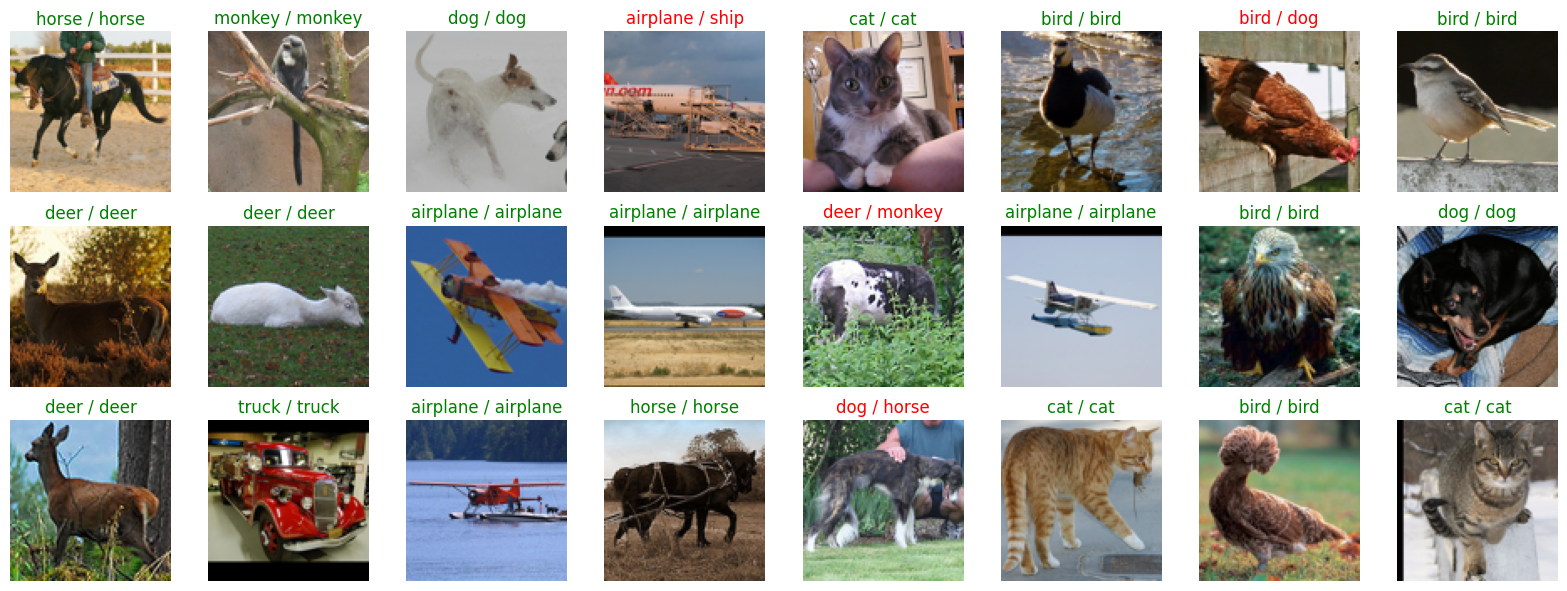

In [ ]:
# ベストモデルの回答の可視化
show_images_STL10(test_dataloader, 3, model, denormalized=True)

正解ラベルとモデルの出力を比べたものになります。  
正しく予測できているものを **緑**、間違って予測しているものを **赤** でタイトルに色付けし、可視化したものです。  
**輪郭が埋もれている画像** などに、誤った予測をしていることが視覚的に確認できます。

### **学習曲線 による可視化**


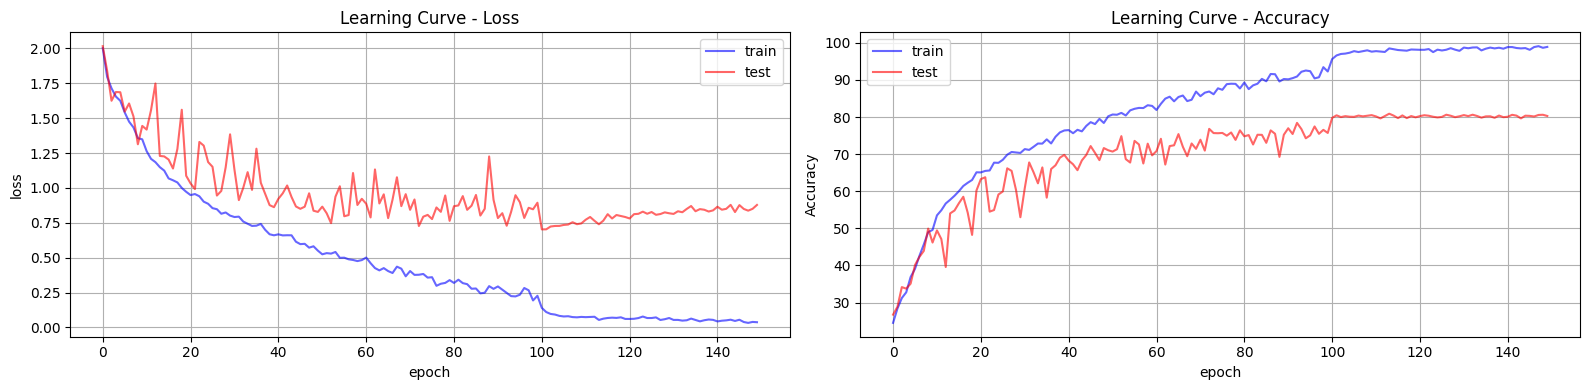

In [ ]:
show_learning_curve(train_losses, train_accs, test_losses, test_accs)

**Loss（左図）** はだんだんと下がり、 **正確度（右図）** はだんだん上がっていることが確認でき、  
学習回数を増やすごとにモデルが画像の特徴を捉えて、認識していることがわかる。  
100エポック目でスケジューラーでLearning Rateの変更ことにより、出力が安定している。

### **Class Activation Map（CAM）による可視化**  


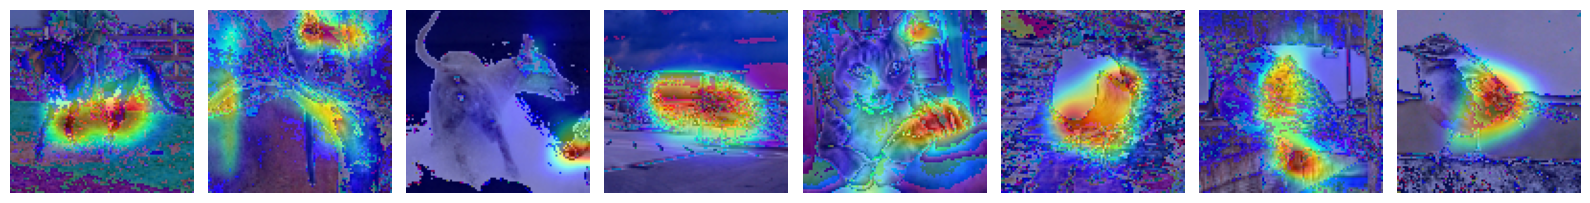

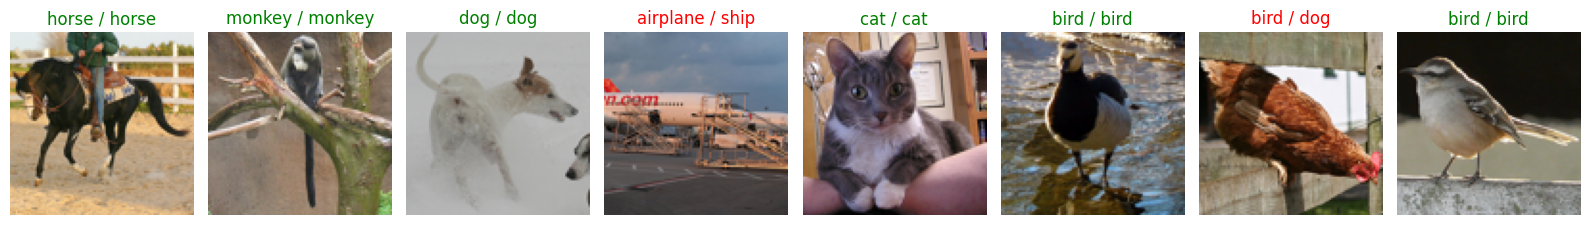

In [ ]:
show_CAM_STL10(test_dataloader, model)

"**モデルの目線**" を覗き見るような感覚で、学習の理解を深めることができ、  
画像全体の中で、モデルが特に強く反応した領域を赤く表示され、分類結果の根拠を直感的に捉えるのに役立ちます。

## ▼おわりに


本ノートブックでは、  
STL-10を対象に、 **ResNet構造をベースとした画像分類モデル** の実装と検証を行いました。  
  
* **ResNet-34** の構造を踏襲しながらも、チャンネル数を **3→64→128→256→512** と、段階的に抽出
* 深さを維持しつつ、モデル全体の **軽量化と学習の安定性** を両立する構成を策定
* モデル構造・学習方針・可視化などを通じて、 **残差構造の有効性** や、 **柔軟なモデル設計の重要性** の実感  

これらの設計により、限られたデータ量とリソースでも高精度な分類性能を発揮し、  
STL-10に対して **80.90%の精度** のモデルの構築ができました。  
  
本実装を通じて得られた知見は、今後におけるモデル設計・最適化にも活かせる貴重な経験となりました。
  
---
  
最後までご覧いただき、ありがとうございました。  
今後もこの知見を元に、より深い知識と技術を身につけていけるよう、継続して取り組んでまいります。